# Introduction to SymPy and FEniCS

## SymPy: Symbolic mathematics in Python

SymPy is a powerful symbolic mathematics package with similar features as Mathematica. We will use this to perform calculus with parametric functions, e.g. differentiation and integration. For this we create the finite element basis of linear elements in one dimension on the arbitrary element $(a,b)$. The basis is then given by
$$
\begin{align}
\varphi_1(x) &= \frac{x-a}{b-a}, \\
\varphi_2(x) &= 1-\frac{x-a}{b-a}.
\end{align}
$$

In the first step we create these two functions and plot them with matplotlib for $a=2$ and $b = 5$.

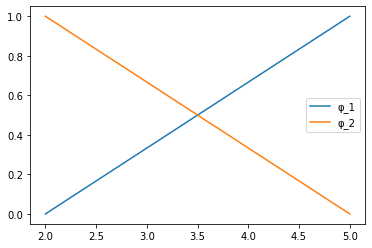

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from IPython.display import Math, display

a, b, x = symbols("a b x")
init_printing()

# create the functions
φ_1 = (x-a) / (b-a)
φ_2 = 1-(x-a) / (b-a)

X = np.linspace(2., 5., 100)
# evaluate basis functions for each point in X given that a = 2 and b = 5
Y1 = [φ_1.evalf(subs={a: 2, b:5, x:_x}) for _x in X]
Y2 = [φ_2.evalf(subs={a: 2, b:5, x:_x}) for _x in X]
plt.plot(X, Y1, label="φ_1")
plt.plot(X, Y2, label="φ_2")
plt.legend()
plt.show()

# ALTERNATIVE: plot(φ_1.evalf(subs={a: 2, b:5}), (x, 2, 5))

We can also compute derivatives:

The derivative of φ_1 w.r.t. x is:


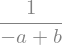

In [2]:
print("The derivative of φ_1 w.r.t. x is:")
diff(φ_1, x)

The derivative of φ_2 w.r.t. x is:


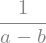

In [3]:
print("The derivative of φ_2 w.r.t. x is:")
simplify(diff(φ_2, x)) # NOTE: With simplify SymPy tries to find a simpler representation of the expression

Finally, we can also integrate functions symbolically:

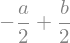

In [4]:
simplify(integrate(φ_1, (x, a, b)))

## FEniCS: Finite Element Method package

In [5]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

We will explain how FEniCS works by considering the Poisson equation in two spatial dimensions.
The Poisson equation is given by
$$
-\Delta u = f \qquad \text{in } \Omega := (0,1) \times (0,1).
$$
Here, $\Delta u := \partial_{xx} u + \partial_{yy} u$ is the Laplace operator in two dimensions.
We choose the analytical solution $u(x,y) := x(1-x)y(1-y)$ and use it for the Dirichlet boundary conditions, i.e.
$$ 
u = x(1-x)y(1-y) \qquad \text{on } \partial \Omega. 
$$
The right hand side $f$ is being derived by plugging the analytical solution into the PDE:
$$
f(x,y) = -\Delta u = -\partial_{xx}\left[x(1-x)\right]y(1-y) - x(1-x)\partial_{yy}\left[y(1-y)\right] = 2y(1-y) + 2x(1-x).
$$

The variational formulation is: Find $u \in V$ such that
$$
\int_{\Omega} \nabla u \cdot \nabla \varphi\ \mathrm{d}(x) = \int_{\Omega} f\varphi\ \mathrm{d}(x) \qquad \forall \varphi \in V.
$$

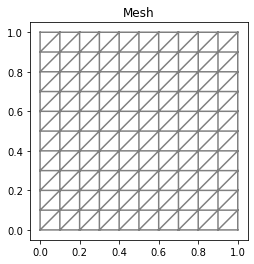

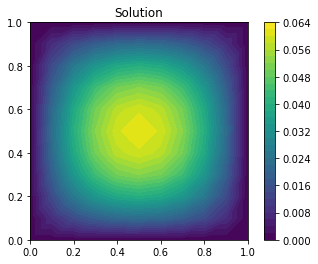

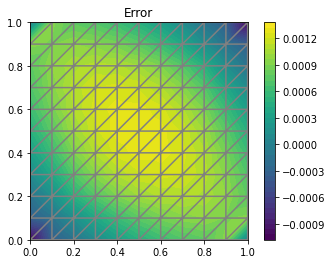

L2 error: 0.0009288815828313381


In [6]:
from fenics import *
import matplotlib.pyplot as plt
import math

set_log_active(False) # turn off FEniCS logging

n_x = 10
n_y = 10

mesh = UnitSquareMesh(n_x, n_y)
# ALTERNATIVE: mesh = RectangleMesh(Point(0.,0.), Point(1.,1.), n_x, n_y)
plt.title("Mesh")
plot(mesh)
plt.show()

V = FunctionSpace(mesh, 'P', 1)

# Analytical solution U is used as Dirichlet BC
U = Expression('x[0]*(1.-x[0])*x[1]*(1.-x[1])', degree=2)
# NOTE: You can also use variables in the expression and then pass the concrete values as keyword arguments
#U = Expression('x[0]*(1.-x[0])*x[1]*(a-x[1])', degree=2, a=1.)
bc = DirichletBC(V, U, lambda _, on_boundary: on_boundary)

# Define variational problem
f = Expression('2.*x[1]*(1.-x[1]) + 2.*x[0]*(1.-x[0])', degree=2, pi=math.pi)
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u),grad(v))*dx
L = f*v*dx

# Solve
u_h = Function(V)
solve(a == L, u_h, bc)

# Plot solution and error
plt.title("Solution")
c = plot(u_h)
plt.colorbar(c)
plt.show()

plt.title("Error")
c = plot(U-u_h)
plot(mesh)
plt.colorbar(c)
plt.show()

print(f"L2 error: {errornorm(U, u_h, 'L2')}")